A Guide to building a Quantiative Ratings System

In [36]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb


In [2]:
def clip_to_percentiles(column, min_percentile, max_percentile):
    lower = column.quantile(min_percentile)
    upper = column.quantile(max_percentile)
    return column.clip(lower, upper)

In [3]:
#url = "https://raw.githubusercontent.com/adam-datasci/RiskAnalytics/main/Data/american_bankruptcy.csv?"
url = "Data/american_bankruptcy_normalized.csv"
df = pd.read_csv(url)

In [4]:
features = [
    'wc_to_ta_pct',
    're_to_ta_pct',
    'ebit_to_ta_pct',
    'mv_to_tl_pct',
    'tr_to_ta_pct',
    'tltd_to_te_pct',
    'np_to_tr_pct',
    'ebitda_to_tr_pct',
    'gp_to_tr_pct',
    'ca_to_cl_pct',
    'np_to_ta_pct',
    'default',
    'z_score'
    ]


features = [
    'wc_to_ta_pct',
    're_to_ta_pct',
    'ebit_to_ta_pct',
    'mv_to_tl_pct',
    'tr_to_ta_pct',
    'default',
    'z_score'
    ]

industries = ['Agriculture','Mining','Construction','Manufacturing','Transportation','Wholesale','Retail','Finance','Services','Public']
industries = ['Manufacturing']
industries = ['Manufacturing','Services','Transportation and Comms']

df_filtered = df[df['Division'].isin(industries)]
df_filtered = df_filtered[features]

In [5]:
#for feature in features[:-1]:
 #   df_filtered[feature] = clip_to_percentiles(df[feature],0.05,0.95)

In [6]:
#Create a sample of a specific size for the filtered data
sample_size = 1000
df_filtered_sample = df_filtered.sample(sample_size, random_state=1)

#pull out both the default and non-default periods
default_periods = df_filtered[df['default'] == 1]
non_default_periods = df_filtered[df['default'] == 0]
no_rows = default_periods.shape[0]

#Create a balanced dataset
df_sample_non_default = non_default_periods.sample(no_rows, random_state=1)
df_balanced = pd.concat([default_periods, df_sample_non_default])

X = df_balanced.drop(['default','z_score'], axis=1)
y = df_balanced['default']
z_scores = df_balanced['z_score']


C:\Users\adamk\AppData\Local\Temp\ipykernel_4280\3418997923.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  default_periods = df_filtered[df['default'] == 1]
C:\Users\adamk\AppData\Local\Temp\ipykernel_4280\3418997923.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  non_default_periods = df_filtered[df['default'] == 0]


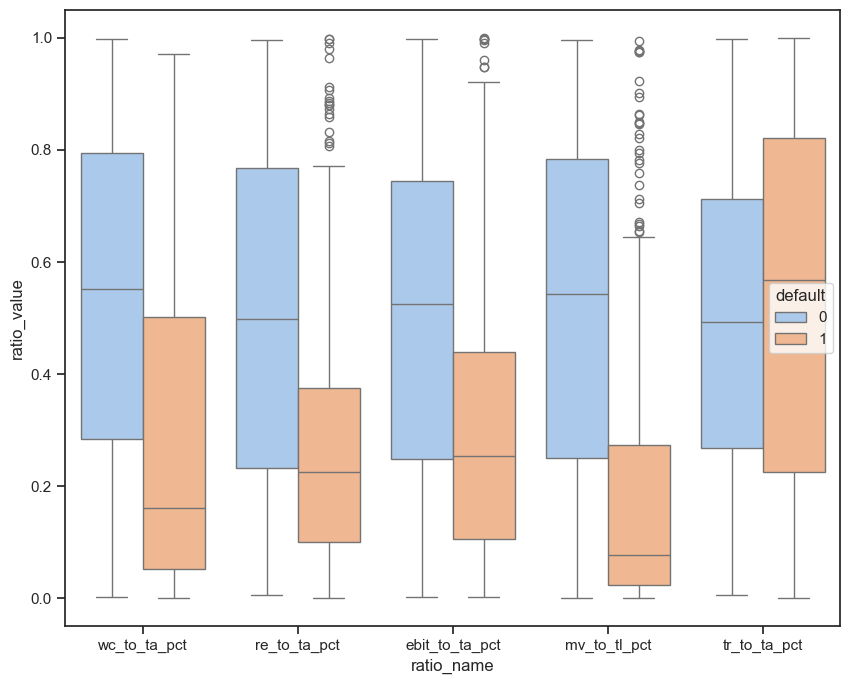

In [7]:
df_filtered_sample_by_status = df_balanced.melt(id_vars='default', value_vars=features[:-1],var_name='ratio_name',value_name='ratio_value')

plt.figure(figsize=(10, 8))
sns.set_theme(style="ticks", palette="pastel")
sns.boxplot(x='ratio_name', y='ratio_value', hue='default', data=df_filtered_sample_by_status)
plt.show()

In [8]:
#min_max_scaler = MinMaxScaler(feature_range=(0, 1))

#df_balanced = pd.DataFrame(min_max_scaler.fit_transform(df_balanced), columns=df_balanced.columns, index=df_balanced.index)

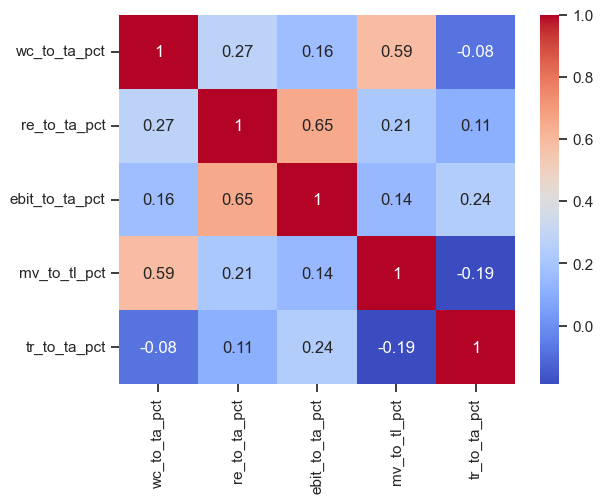

In [9]:
correlation_matrix = X.corr()

# Heatmap of the correlation matrix
dataplot = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [ ]:
#Logit Regression
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# SVM
svm_model = SVC(probability=True)  # Enable probability estimate for ROC curve
svm_model.fit(X_train, y_train)

#XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# Decision Tree
tree_model = DecisionTreeClassifier(max_depth=3)
tree_model.fit(X_train, y_train)

#predictions_logit = result.predict(X_test)
#predicted_classes_logit = (predictions_logit > 0.5).astype(int)
#model = XGBClassifier(learning_rate =0.1, randon_state=42)
#result = model.fit(X_train,y_train)

In [37]:
tree_rules = export_text(tree_model, feature_names=list(X_train.columns))
print(tree_rules)

|--- mv_to_tl_pct <= 0.15
|   |--- re_to_ta_pct <= 0.46
|   |   |--- mv_to_tl_pct <= 0.02
|   |   |   |--- class: 1
|   |   |--- mv_to_tl_pct >  0.02
|   |   |   |--- class: 1
|   |--- re_to_ta_pct >  0.46
|   |   |--- ebit_to_ta_pct <= 0.46
|   |   |   |--- class: 1
|   |   |--- ebit_to_ta_pct >  0.46
|   |   |   |--- class: 0
|--- mv_to_tl_pct >  0.15
|   |--- ebit_to_ta_pct <= 0.15
|   |   |--- tr_to_ta_pct <= 0.19
|   |   |   |--- class: 0
|   |   |--- tr_to_ta_pct >  0.19
|   |   |   |--- class: 1
|   |--- ebit_to_ta_pct >  0.15
|   |   |--- mv_to_tl_pct <= 0.34
|   |   |   |--- class: 0
|   |   |--- mv_to_tl_pct >  0.34
|   |   |   |--- class: 0



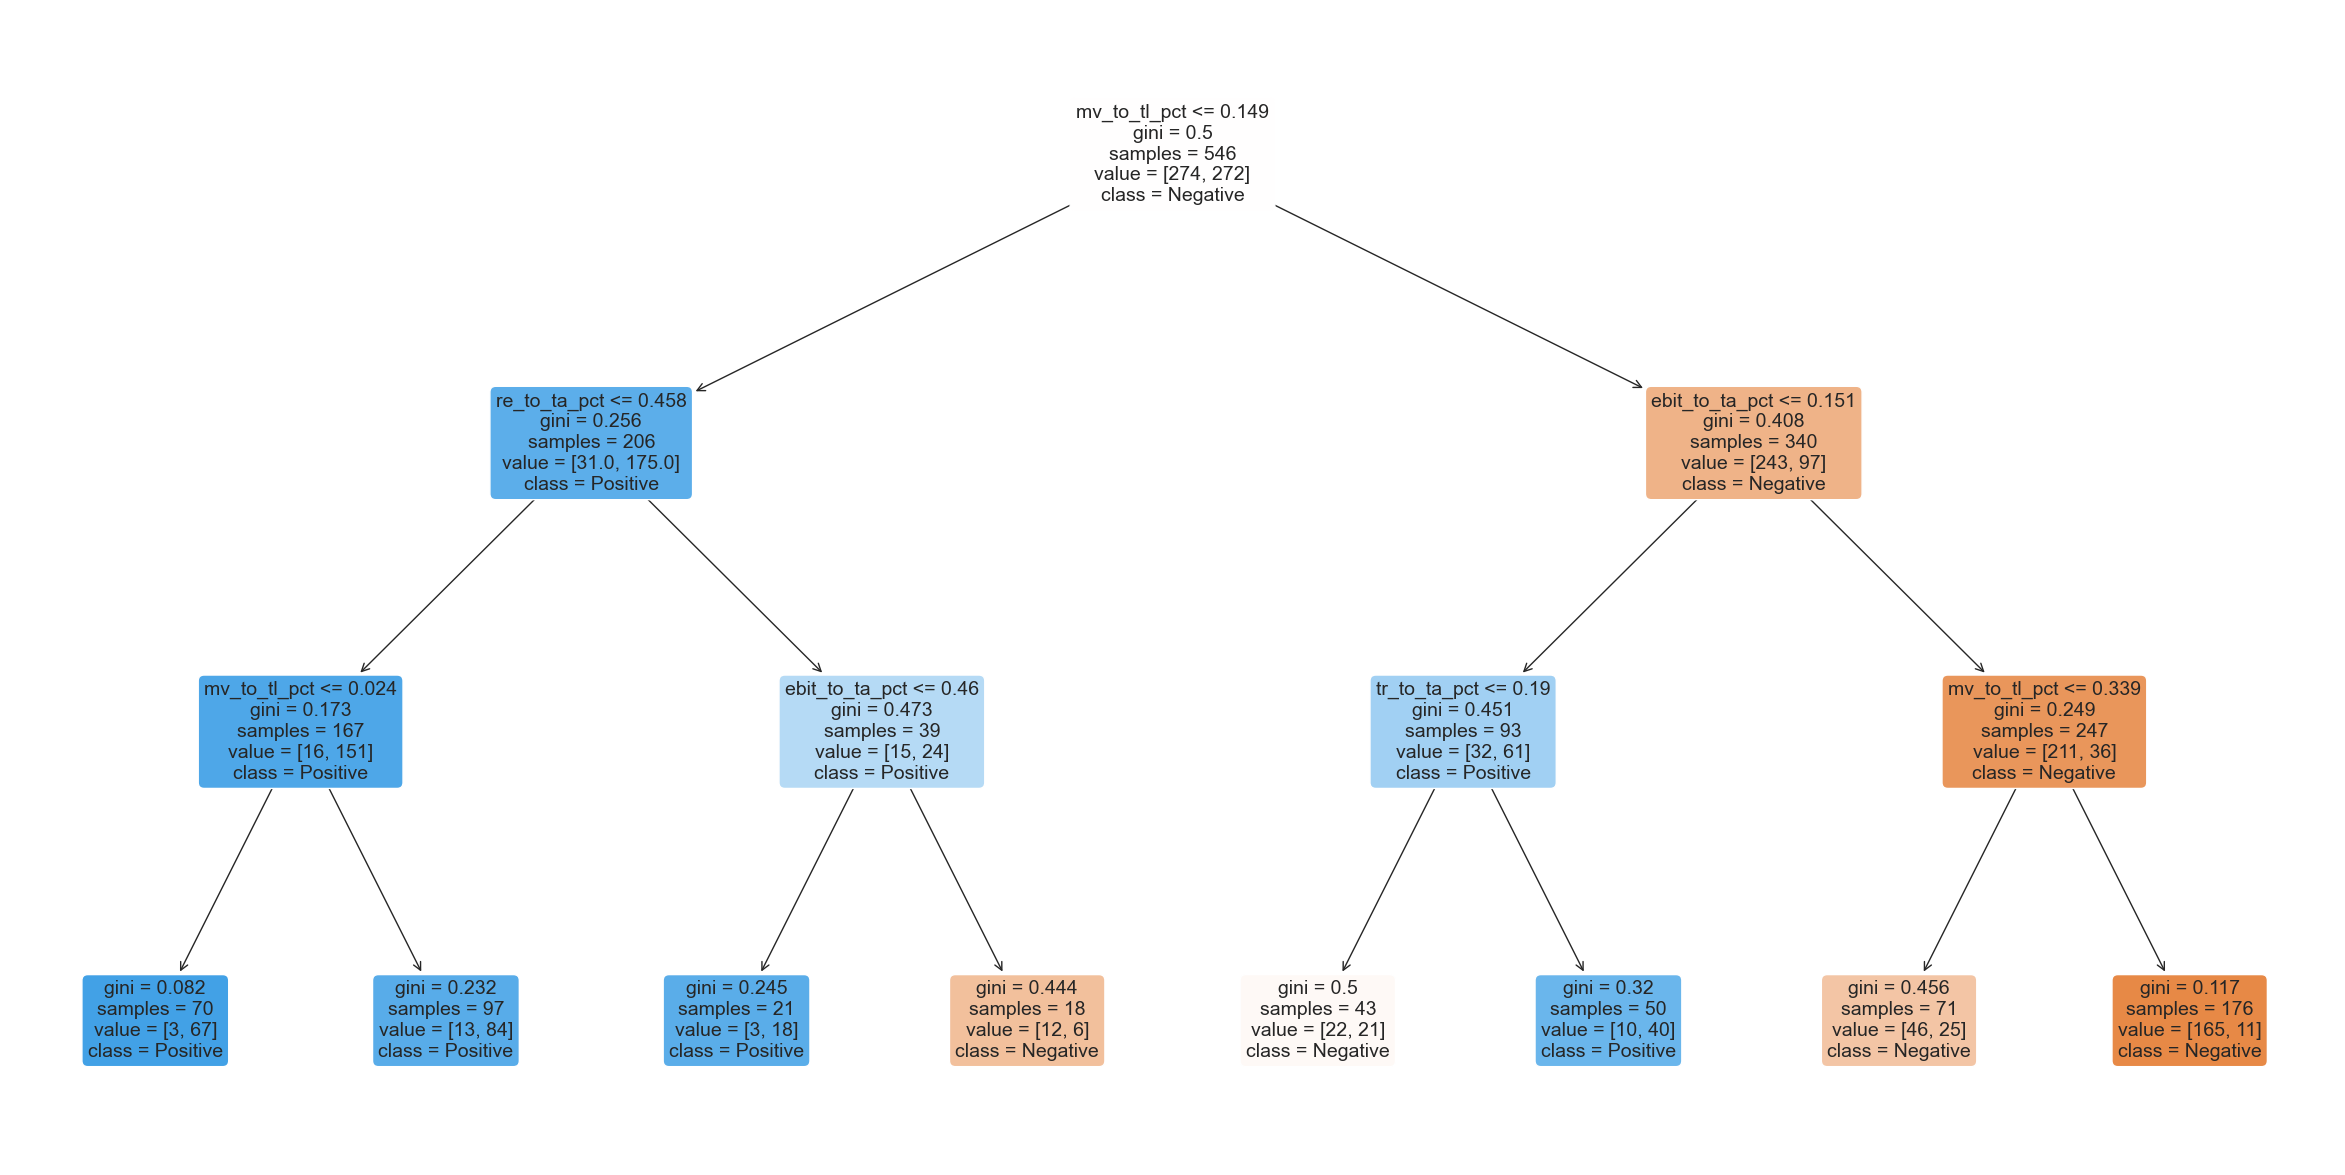

In [26]:
plt.figure(figsize=(30, 15))  # Adjust the size of the plot as needed
plot_tree(tree_model, filled=True, feature_names=X_train.columns, class_names=["Negative", "Positive"], rounded=True, fontsize=14)
plt.show()

In [32]:
logit_pred = result.predict(X_test)
logit_pred_classes = (logit_pred > 0.5).astype(int)

svm_pred = svm_model.predict_proba(X_test)
svm_pred = svm_pred[:,1]
svm_pred_classes = (svm_pred > 0.5).astype(int)

xgb_pred = xgb_model.predict_proba(X_test)
xgb_pred = xgb_pred[:,1]
xgb_pred_classes = (xgb_pred > 0.5).astype(int)

tree_pred = tree_model.predict(X_test)
#tree_pred = tree_pred[:, 1]  # get probabilities for the positive class
#tree_pred_classes = (tree_pred > 0.5).astype(int)  # convert probabilities to 0 or 1 based on a threshold of 0.5

z_score_test = z_scores.loc[X_test.index]
z_score_pred = 1 / (1 + np.exp(z_score_test))
z_score_pred_classes = (z_score_pred > 0.5).astype(int) 




In [13]:
cm1 = confusion_matrix(y_test, logit_pred_classes)
cm2 = confusion_matrix(y_test, svm_pred_classes)
cm3 = confusion_matrix(y_test, xgb_pred_classes)
cm3 = confusion_matrix(y_test, tree_pred_classes)
cm4 = confusion_matrix(y_test, z_score_pred_classes)

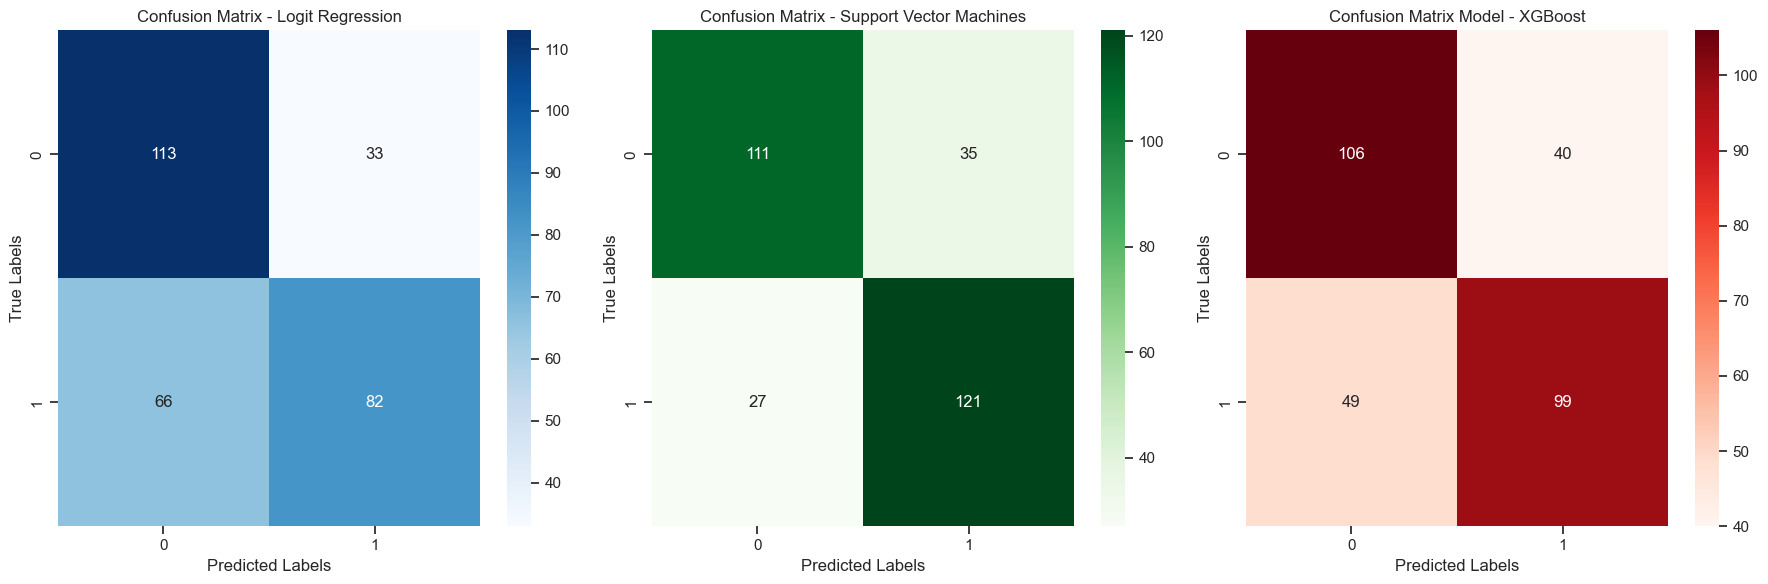

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

sns.heatmap(cm1, annot=True, ax=axes[0], fmt='g', cmap='Blues')
axes[0].set_title('Confusion Matrix - Logit Regression')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(cm2, annot=True, ax=axes[1], fmt='g', cmap='Greens')
axes[1].set_title('Confusion Matrix - Support Vector Machines')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

sns.heatmap(cm3, annot=True, ax=axes[2], fmt='g', cmap='Reds')
axes[2].set_title('Confusion Matrix Model - XGBoost')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout()
plt.show()

In [33]:
fpr1, tpr1, _ = roc_curve(y_test, logit_pred)
roc_auc1 = auc(fpr1, tpr1)
fpr2, tpr2, _= roc_curve(y_test, svm_pred)
roc_auc2 = auc(fpr2, tpr2)
fpr3, tpr3, _= roc_curve(y_test, xgb_pred)
roc_auc3 = auc(fpr3, tpr3)
fpr4, tpr4, _= roc_curve(y_test, z_score_pred)
roc_auc4 = auc(fpr4, tpr4)
fpr5, tpr5, _= roc_curve(y_test, tree_pred)
roc_auc5 = auc(fpr5, tpr5)

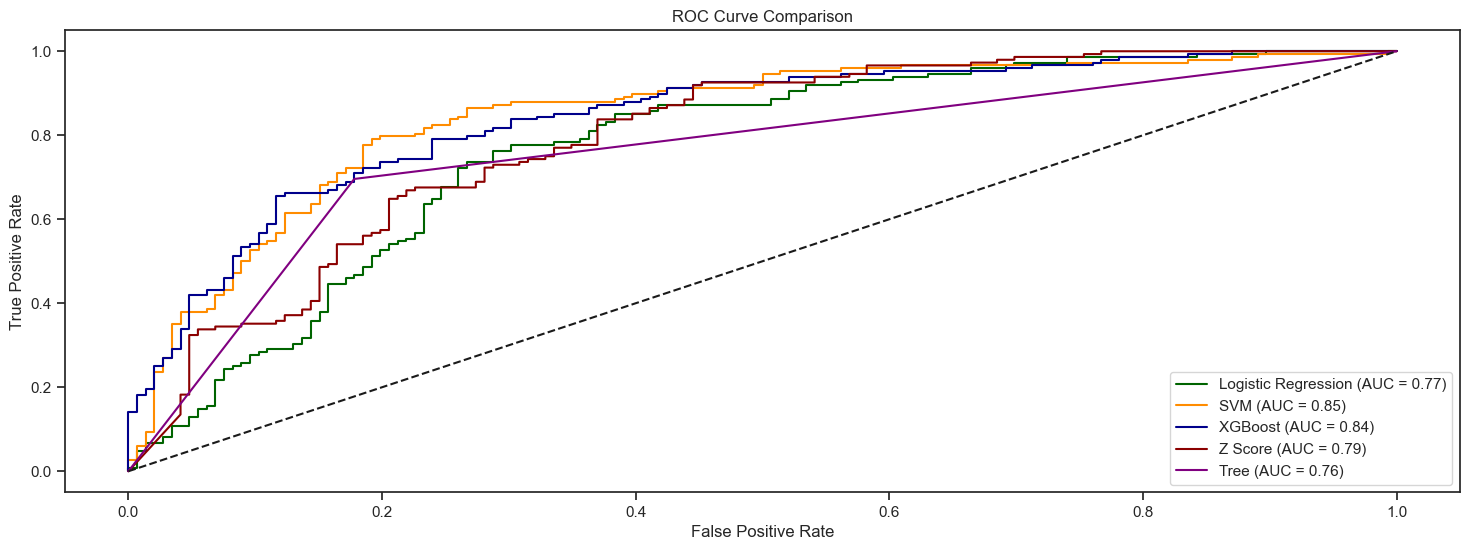

In [34]:
plt.figure(figsize=(18, 6))
plt.plot(fpr1, tpr1, color='darkgreen', label=f'Logistic Regression (AUC = {roc_auc1:.2f})')
plt.plot(fpr2, tpr2, color='darkorange', label=f'SVM (AUC = {roc_auc2:.2f})')
plt.plot(fpr3, tpr3, color='darkblue', label=f'XGBoost (AUC = {roc_auc3:.2f})')
plt.plot(fpr4, tpr4, color='darkred', label=f'Z Score (AUC = {roc_auc4:.2f})')
plt.plot(fpr5, tpr5, color='purple', label=f'Tree (AUC = {roc_auc5:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

In [17]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  546
Model:                          Logit   Df Residuals:                      541
Method:                           MLE   Df Model:                            4
Date:                Tue, 30 Apr 2024   Pseudo R-squ.:                  0.2377
Time:                        20:07:29   Log-Likelihood:                -288.49
converged:                       True   LL-Null:                       -378.45
Covariance Type:            nonrobust   LLR p-value:                 7.723e-38
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
wc_to_ta_pct       0.1258      0.399      0.315      0.752      -0.656       0.908
re_to_ta_pct      -1.3475      0.502     -2.685      0.007      -2.331      -0.364
ebit_to_ta_pct    -1.2322      0.491     -2.510      0.012      -2.194      -0.270
mv_to_tl_pct      -2.3743      0.424     -5.595      0.000      -3.206      -1.543
tr_to_ta_pct       2.7693      0.315      8.799      0.000       2.152       3.386
==================================================================================
"""

In [ ]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

# Print the coefficients
print("Coefficients:", lda.coef_)

# You can also explore how well it separates the classes
print("Class separation:", lda.explained_variance_ratio_)

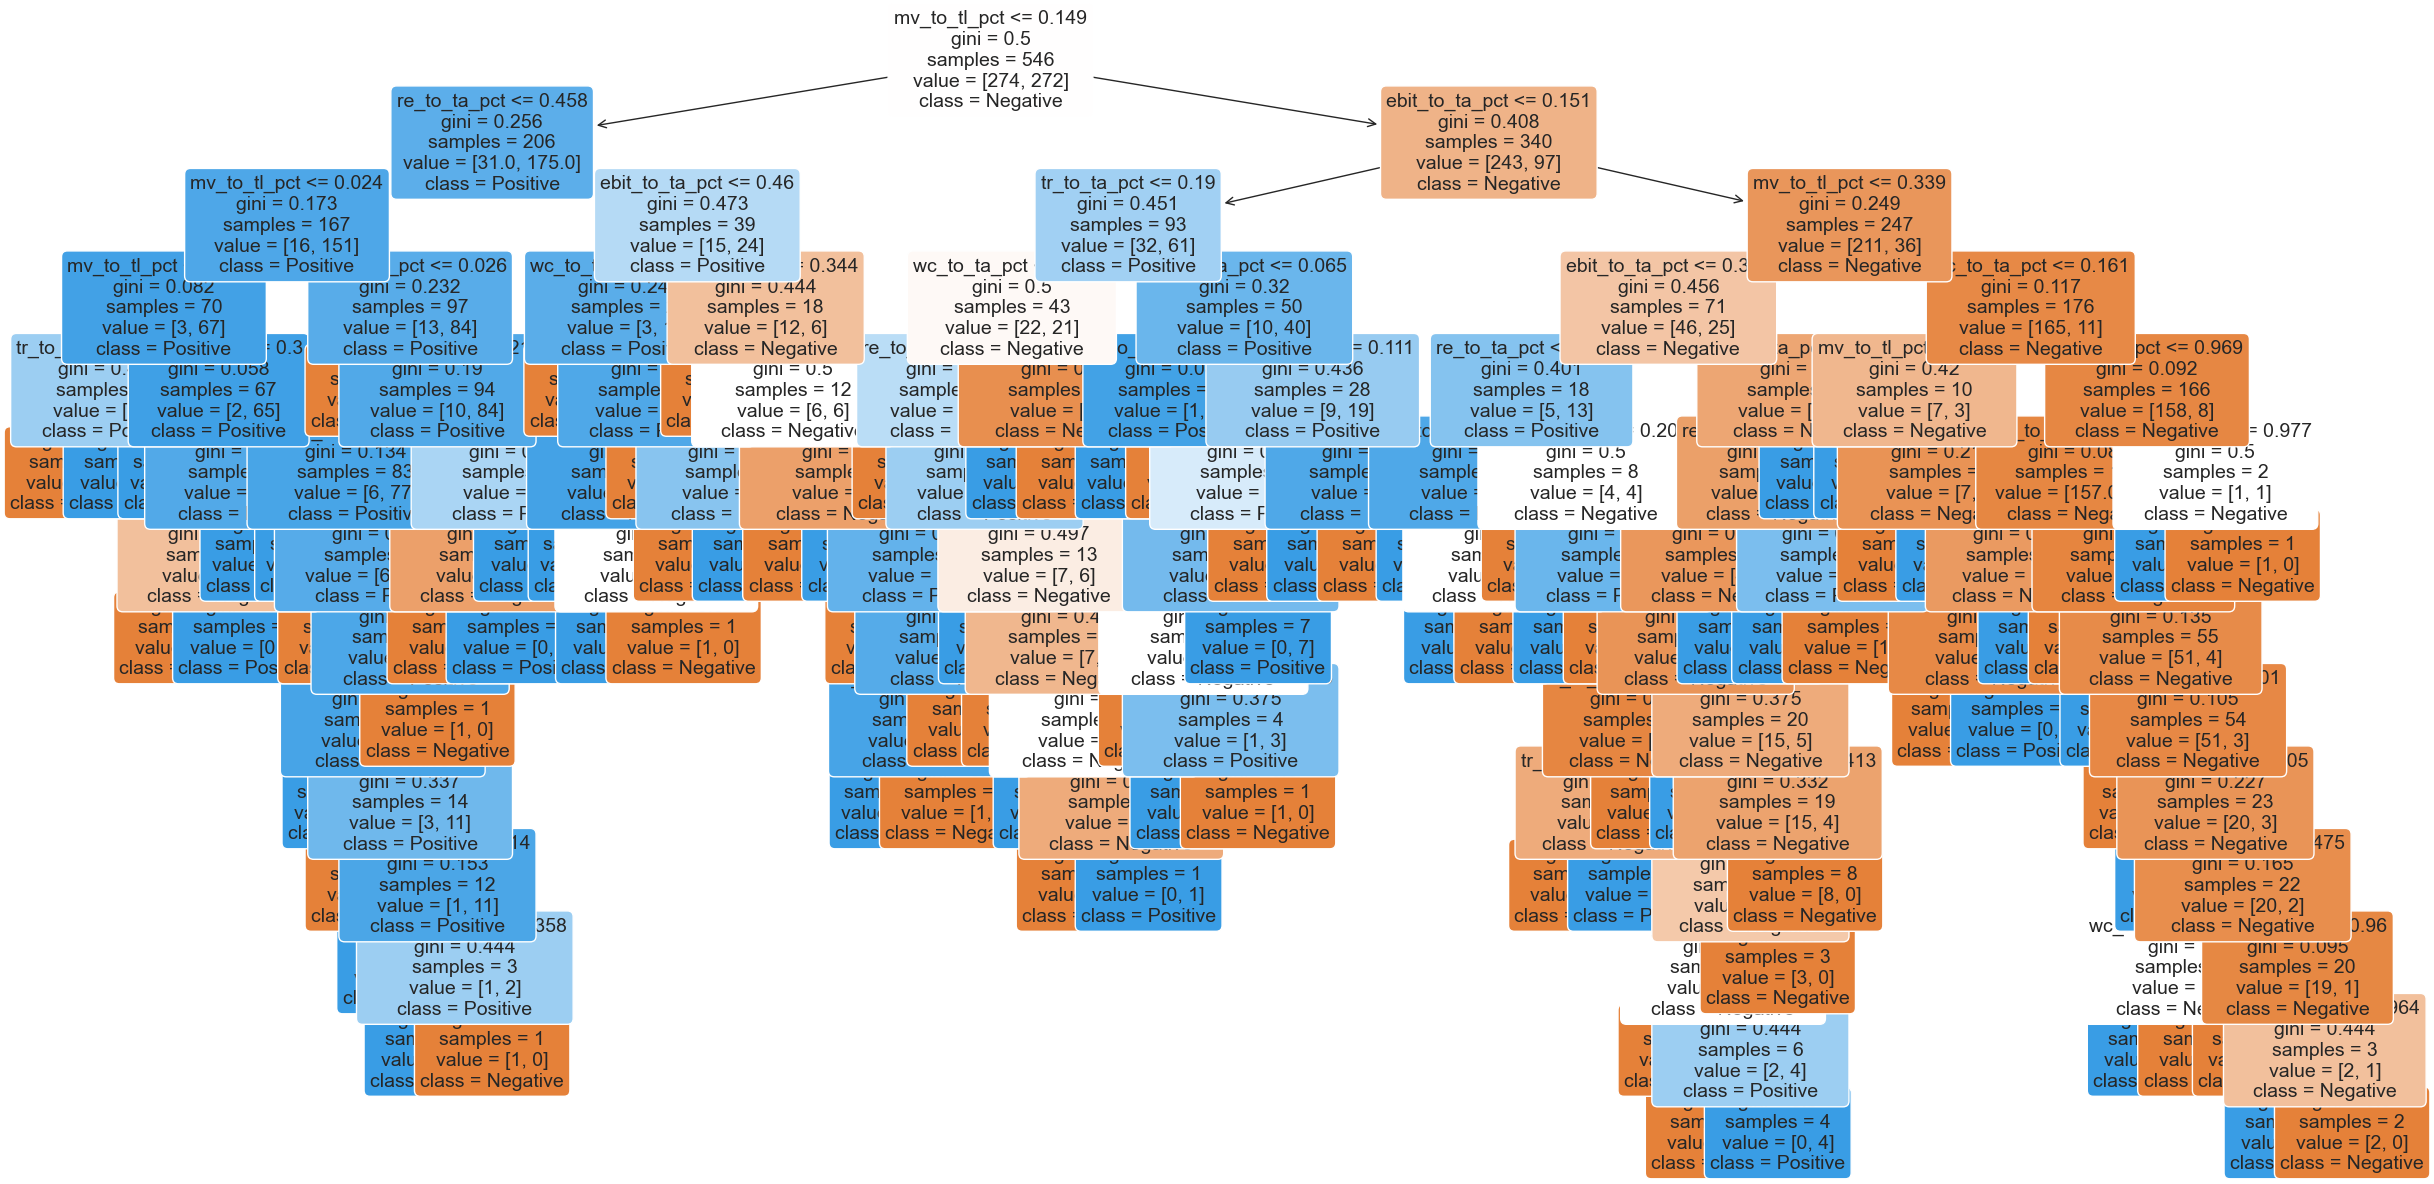

In [24]:
plt.figure(figsize=(30, 15))  # Adjust the size of the plot as needed
plot_tree(tree_model, filled=True, feature_names=X_train.columns, class_names=["Negative", "Positive"], rounded=True, fontsize=14)
plt.show()
